In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
#initiate device (CPU or GPU)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    devuce = 'cpu'

# Preprocess CIFAR-10 dataset

In [3]:
#preprocess CIFAR-10 data to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#download CIFAR-10 datasets both train and test
train_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#use pytorch loader to pass data in batches
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 200, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 200, shuffle=True, num_workers=0)

In [5]:
images_sample, labels_sample = next(iter(train_loader))
print('Format of CIFAR-10 images: ',images_sample.size(), ' = format([Batch Size, Color dim, Width, Height])\n')
print('STEP 1: Squish the incoming batch of images to a 1D Tensor with size of first input layer:') 
print(images_sample[2].size(), ' -----> ', images_sample[2].view(images_sample[2].size(0), -1).size())
print('\nNOTE, the squished Tensor is still a 2D tensor but the x dimension is only of length 1, making it')
print('essentially a 1D tensor in the Y-Axis\n')

print('Our model is going to apply strided convolutions with a magnitude of 2.')
print('This will downsize our images height and width by half each convolution\n')
conv_test = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=2, padding=1)
print('After convolution:',conv_test(images_sample).size(), '. As you can see, the width and height have halved but the color dimension increased to 16\n')

print('STEP 2: Feed batch of images through the MLP\n')
print('STEP 3: Train the model\n')
print('STEP 4: Test the model\'s accuracy')

Format of CIFAR-10 images:  torch.Size([200, 3, 32, 32])  = format([Batch Size, Color dim, Width, Height])

STEP 1: Squish the incoming batch of images to a 1D Tensor with size of first input layer:
torch.Size([3, 32, 32])  ----->  torch.Size([3, 1024])

NOTE, the squished Tensor is still a 2D tensor but the x dimension is only of length 1, making it
essentially a 1D tensor in the Y-Axis

Our model is going to apply strided convolutions with a magnitude of 2.
This will downsize our images height and width by half each convolution

After convolution: torch.Size([200, 16, 16, 16]) . As you can see, the width and height have halved but the color dimension increased to 16

STEP 2: Feed batch of images through the MLP

STEP 3: Train the model

STEP 4: Test the model's accuracy


# Visualize CIFAR-10 Images

In [6]:
#reverse normalize the pytorch transformation

class Reverse_Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for tensor, mean, std in zip(tensor, self.mean, self.std):
            tensor.mul_(std).add_(mean)
            # The normalize code -> tesnor.sub_(mean).div_(sd)
        return tensor

Corresponding respective labels:  ['frog', 'deer', 'deer', 'cat', 'deer', 'automobile']


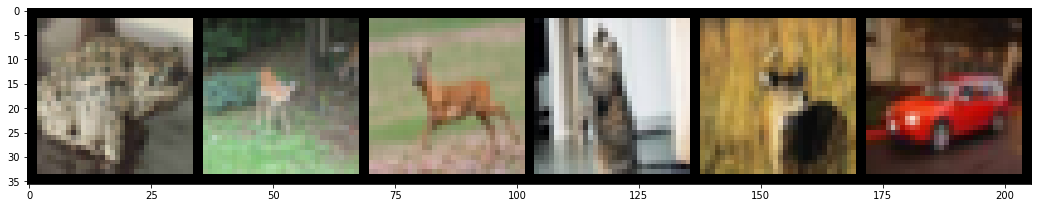

In [7]:
#reverse normalize normalized images
reverse_norm = Reverse_Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#the labels in CIFAR-10 are labeled in ordinal numeric fashion where 0 is airplane and 4 is deer
cifar_labels = ['Airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#copy image samples and label samples

image_view, label_view = copy.deepcopy(images_sample), copy.deepcopy(labels_sample)

for image in image_view[:6]:
    image = reverse_norm(image)
grid_img = torchvision.utils.make_grid(image_view[:6], nrow=6)
fig, ax = plt.subplots(figsize=(18, 4))
ax.imshow(grid_img.permute(1, 2, 0))
print('Corresponding respective labels: ', [cifar_labels[i] for i in label_view[:6].tolist()])

# Define Convolutional Model

In [8]:
def pick_activation(string): #default is relu
        if string == 'relu':
            return nn.ReLU()
        if string == 'tanh':
            return nn.Tanh()

class CNN_Classifier(nn.Module):
    def __init__(self, activation='relu'):
        super(CNN_Classifier, self).__init__()
        #input is 32x32x3 (W, H, C)
        self.activation = nn.ReLU()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        #result is 16x16x16
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        #result is 8x8x32

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        #result is 4x4x64

        #ff layer
        self.dp1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(4*4*64, 512)
        self.bn4 = nn.BatchNorm1d(512)

        self.dp2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn5 = nn.BatchNorm1d(256)

        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        #input coming in 32x32x3

        x = self.conv1(x)
        x = self.activation(x)
        x = self.bn1(x)
        #result 16x16x16

        x = self.conv2(x)
        x = self.activation(x)
        x = self.bn2(x)
        #result 8x8x32

        x = self.conv3(x)
        x = self.activation(x)
        x = self.bn3(x)
        #result = 4x4x64

        #reshape 3D tensor in a "1D" (2D tensor acting like a 1D tensor)
        x = x.view(x.size(0), -1)
        #resulting tensor will be [4x4x64]   to feed through network

        x = self.dp1(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.bn4(x)

        x = self.dp2(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.bn5(x)

        x = self.fc3(x)

        return x


# Train Model

In [9]:
cnn = CNN_Classifier().to(device) #default relu
loss_func = nn.CrossEntropyLoss().to(device) 
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [10]:
epochs = 1000 #how many steps to train

min_loss = np.Inf #lowest loss will be the loaded model

for epoch in range(epochs):
    train_loss = 0  #keep track of training loss

    for images, labels in train_loader:
        cnn.zero_grad()

        outputs = cnn(images.to(device)) #predictions
    
        loss = loss_func(outputs, labels.to(device))   #calculating loss
        loss.backward()
                            
        optimizer.step()    #updating weights

        train_loss += loss.item()/len(images)

    if epoch % 10 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   #print lowest loss
        min_loss = train_loss
        torch.save(cnn.state_dict(), 'saved_model/best_model.pt')   #save model to file

Epoch: 0, Train Loss: 1.8714, Current Min Loss: inf

Epoch: 10, Train Loss: 0.7872, Current Min Loss: 0.8253

Epoch: 20, Train Loss: 0.5432, Current Min Loss: 0.5591

Epoch: 30, Train Loss: 0.4316, Current Min Loss: 0.4439

Epoch: 40, Train Loss: 0.3764, Current Min Loss: 0.3692

Epoch: 50, Train Loss: 0.3287, Current Min Loss: 0.3286

Epoch: 60, Train Loss: 0.2947, Current Min Loss: 0.3008

Epoch: 70, Train Loss: 0.2754, Current Min Loss: 0.2752

Epoch: 80, Train Loss: 0.2623, Current Min Loss: 0.2513

Epoch: 90, Train Loss: 0.2386, Current Min Loss: 0.2422

Epoch: 100, Train Loss: 0.2291, Current Min Loss: 0.2254

Epoch: 110, Train Loss: 0.2196, Current Min Loss: 0.2145

Epoch: 120, Train Loss: 0.2072, Current Min Loss: 0.2015

Epoch: 130, Train Loss: 0.1963, Current Min Loss: 0.1970

Epoch: 140, Train Loss: 0.1902, Current Min Loss: 0.1889

Epoch: 150, Train Loss: 0.1881, Current Min Loss: 0.1841

Epoch: 160, Train Loss: 0.1831, Current Min Loss: 0.1781

Epoch: 170, Train Loss: 0.18

# Load and Test Model

In [30]:
model = CNN_Classifier().to(device)
model.load_state_dict(torch.load('saved_model/best_model.pt'))    #load model
print('Model Loaded: ')
print(model)

Model Loaded: 
CNN_Classifier(
  (activation): ReLU()
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dp2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [47]:
#array with length equal to # of unique labels in CIFAR-10
#each index will represent the label it corresponds to (eg. right[4] == right[deer])
right = np.zeros((10), dtype=int)
wrong = np.zeros((10), dtype=int)

for images, labels in test_loader:
    outputs = model(images.to(device))

    for i in range(len(image)):
        if (torch.argmax(outputs[i]) == labels[i]).tolist():
            right[labels[i].tolist()] += 1
        else:
            wrong[[labels[i].tolist()]] += 1

for i in range(10):
    print('Accurcacy for {}: {:.4f}'.format(
        [cifar_labels[i]],
        (right[i]/(right[i] + wrong[i]))
    ))
print('Total Accuracy of Model: {:.4f}'.format(
    sum(right)/(sum(right) + sum(wrong))
))

Accurcacy for ['Airplane']: 0.7719
Accurcacy for ['automobile']: 0.8627
Accurcacy for ['bird']: 0.5488
Accurcacy for ['cat']: 0.5974
Accurcacy for ['deer']: 0.6478
Accurcacy for ['dog']: 0.5613
Accurcacy for ['frog']: 0.7811
Accurcacy for ['horse']: 0.7143
Accurcacy for ['ship']: 0.8037
Accurcacy for ['truck']: 0.7697
Total Accuracy of Model: 0.7069


# Visualize Model Predictions

Corresponding Classification Results:  ['Airplane', 'deer', 'automobile', 'dog', 'ship', 'automobile']


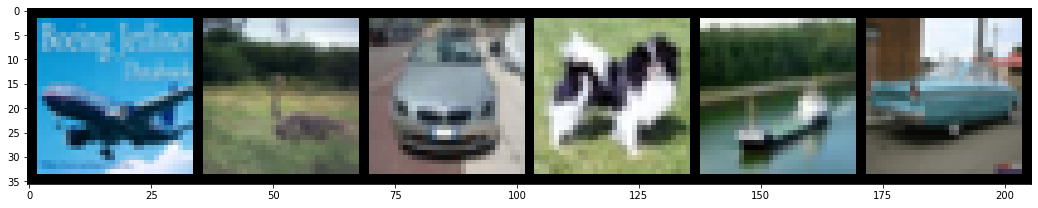

In [56]:
images, labels = next(iter(test_loader))
output_test = model(images.to('cuda'))
output_list = []
#picking out the predictions of the model
for i in range(6):
    output_list.append([torch.argmax(output_test[i]).tolist()])

#reverse normalize images
for image in images[:6]:
    image = reverse_norm(image)

gri_img = torchvision.utils.make_grid(images[:6], nrow=6)
fig, axi = plt.subplots(figsize=(18, 4))
axi.imshow(gri_img.permute(1, 2, 0))
print('Corresponding Classification Results: ', [cifar_labels[i] for [i] in output_list])